In [2]:
import aptwrapper
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import matplotlib.dates
import datetime as dt

# Laser power and pulse width

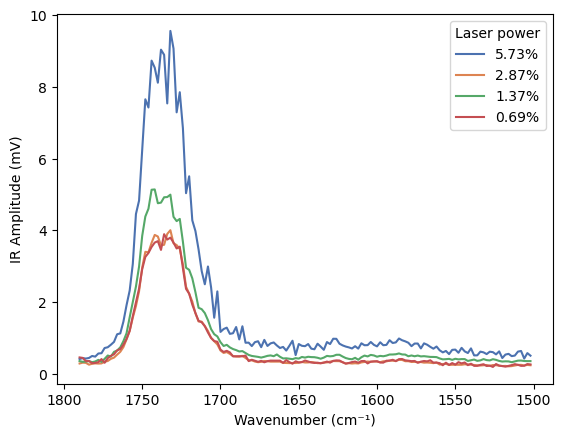

In [3]:
def data_power():
    root = '../primary_data/fig1_optimisation/2022-11-17_power_and_pulse_width/'
    doc = aptwrapper.read(root+'sample 4 pulse width tune.axz')
    doc2 = aptwrapper.read(root+'sample 4 pulse width tune 2.axz')

    spectra = xr.concat(
            list(doc.RenderedSpectra.values()) + list(doc2.RenderedSpectra.values()), 
            dim='si'
        )['IR Amplitude (mV)']

    spectra = spectra.sel(si=spectra.Label!='Spectrum 1')#, v=slice(1510, 1800))

    spectra = (
        spectra
        .assign_coords(
            pulse_width=('si', np.tile(np.arange(200, 60-1, -20), 4))
        ).rename(
            {'pulse_width': 'Pulse width (ns)'}
        ).assign_coords(
            Power=('si', np.round(spectra.AttenuationBase64.data*100,2))
        )
    )
    return spectra

def plot_power(ax=None):
    if ax is None: ax = plt.gca()
    spectra = (
        data_power().sel(v=slice(1502, 1790)).to_dataframe()
        .query('`Pulse width (ns)` == 160')
        .assign(Power = lambda x: x.Power.astype(str) + '%')
    )
    
    sns.lineplot(
        data=spectra, 
        x='v', y='IR Amplitude (mV)', hue='Power',
        legend='full', palette='deep',
        ax=ax
    )
    ax.set_xlabel('Wavenumber (cm⁻¹)')
    ax.invert_xaxis()
    ax.legend(title='Laser power')


plot_power()


At a fixed pulse width of 160 ns, the data starts to get noisy at 5.73% laser power. Spectra below that are all acceptable, but 1.37% gives the highest signal.

# Humidity

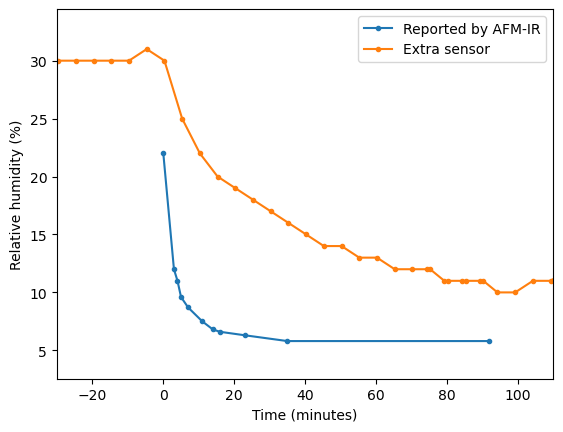

In [4]:
def data_humidity(ax=None):
    if ax is None: ax = plt.gca()

    time_resolution = 'm'

    # AFM-IR reported measurements (logged)
    humidities = [22, 12, 11, 9.6, 8.7, 7.5, 6.8, 6.6, 6.3, 5.8, 5.8]
    times = np.array([dt.datetime(2022,1,28,16+int(t/60),t%60) for t in [13,16,17,18,20,24,27,29,36,48,105]], dtype=np.datetime64)
    dts = (times-times[0]) / np.timedelta64(1, time_resolution)
    ax.plot(dts, humidities, '.-', label='Reported by AFM-IR')
    
    # Sensor measurements
    root = '../primary_data/fig1_optimisation/2022-01-28_humidity/'
    df = pd.read_csv(root+'Aranet4 0A4EF_2022-01-31T09_41_41+0100.csv')
    df.Time = df.Time.map(lambda t: dt.datetime.strptime(t, r'%m/%d/%Y %H:%M:%S'))
    df.Time = (df.Time - times[0]) / np.timedelta64(1, time_resolution)
    ax.plot(df.Time, df['Relative humidity(%)'], '.-', label='Extra sensor')

    # Format xaxis  
    # ax.set_xlim(dt.datetime(2022,1,28,15,50), dt.datetime(2022,1,28,18,10))
    # ax.set_xlabel('Time (hh:mm)')
    # ticks = ax.get_xticks()
    # ax.set_xticks(ticks)  # matplotlib complains when you set fixed tick labels without fixing the ticks themselves
    # ax.set_xticklabels(matplotlib.dates.num2date(t).strftime('%H:%M') for t in ticks)

    # ax.set_xlim(-.2,2)
    ax.set_xlim(-30,110)

    ax.legend()
    ax.set_ylabel('Relative humidity (%)')
    ax.set_xlabel('Time (minutes)')

data_humidity()

Humidity as measured by the AFM-IR drops faster than the humidity measured by the sensor, probably due to the location of the sensor.

# PLL

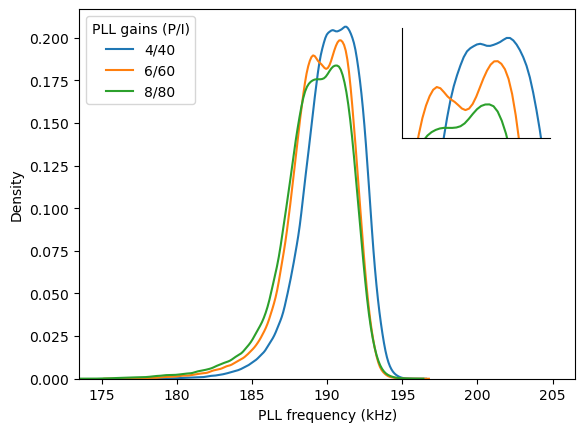

In [5]:
def data_pll(ax=None):
    if ax is None: ax = plt.gca()
    root = '../primary_data/fig1_optimisation/2022-09-01_pll_gains/'
    doc = aptwrapper.read_nocache(root + 'p53 pll60.axz')

    tax = ax.inset_axes([.65,.65,.3,.3])
    tax.set(xticks=[], yticks=[])

    for i in range(5,8):
        pll_trace = doc.HeightMaps[f'PLL Frequency {i}'].data.flatten()
        sns.kdeplot(pll_trace, ax=ax)
        sns.kdeplot(pll_trace, ax=tax)

    ax.set_xlim(171+2.5, 204+2.5)
    ax.legend(['4/40', '6/60', '8/80'], title='PLL gains (P/I)', loc='upper left')
    ax.set_xlabel('PLL frequency (kHz)')
    ax.set_ylabel('Density')
    tax.set_xlim(188,192.5)
    tax.set_ylim(.172,.21)
    sns.despine(ax=tax)
    
data_pll()

6/60 is the best!

# XY drift

Average drift: 4.8724526226861204 nm/min
Total drift: 4305.6723177397525 nm


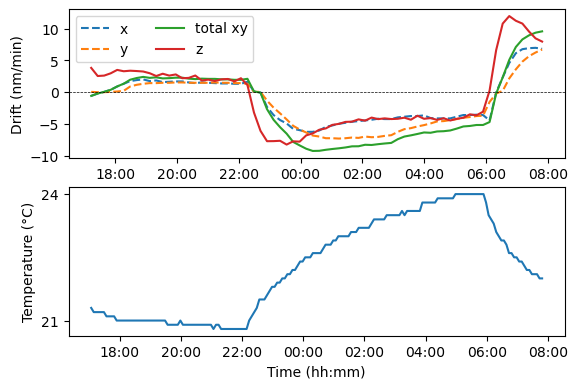

In [6]:
from skimage.registration import phase_cross_correlation
from datetime import datetime

def data_drift_direct(ax=None):
    if ax is None: fig, ax = plt.subplots(2)

    # Read in data
    doc = aptwrapper.read('../primary_data/fig1_optimisation/2021-12-08_overnight_drift/2021-12-08 overnight drift 2x2um.axz')
    maps = [v for k, v in doc.HeightMaps.items() if 'Height' in k]
    z_mean = [h.mean().item() for h in maps]

    # Calculate time differences
    times = np.array([h.TimeStamp.item() for h in maps]).astype('datetime64[ns]')
    # dt = (times[:-1] - times[0]) / 60e9 # minutes
    timestep = (times[1]-times[0]) / np.timedelta64(1, 'm')# minutes
    # dt_hours = dt / 60 # hours
    
    # Calculate drift
    xdrift, ydrift, zdrift, rmse = [], [], [], []
    for i in range(len(maps)-1):
        im1 = aptwrapper.subtract_lines(maps[i]).data
        im2 = aptwrapper.subtract_lines(maps[i+1]).data
        transform, _, _ = phase_cross_correlation(im1, im2, upsample_factor=10) 
        xdrift.append(transform[0] * maps[i].X.diff('x').data[0,0] * 1e3)
        ydrift.append(transform[1] * maps[i].X.diff('x').data[0,0] * 1e3)
        rmse.append(np.sqrt(np.mean((im1 - im2)**2)))

    # Read temperature data
    data_temp = pd.read_csv('../primary_data/fig1_optimisation/2021-12-08_overnight_drift/2021-12-08 overnight drift - c02.csv')
    data_temp.Time = data_temp.Time.map(
        lambda d: datetime.strptime(d, r'%m/%d/%Y %I:%M:%S %p')
    )

    # data_temp.Time = (data_temp.Time - times[0]) / np.timedelta64(1, 'h')
    data_temp = data_temp.query('@times[0] < Time < @times[-1]')

    # Plot drift
    ax[0].plot(times[1:], xdrift/timestep, label='x', ls='--')
    ax[0].plot(times[1:], ydrift/timestep, label='y', ls='--')
    ax[0].plot(times[1:], np.sqrt(np.power(xdrift, 2) + np.power(ydrift, 2))/timestep * np.sign(xdrift), label='total xy')
    ax[0].plot(times[1:], np.diff(z_mean)/timestep, label='z')
    ax[0].legend(loc='upper left', ncols=2)
    ax[0].set(ylabel='Drift (nm/min)')
    ax[0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))

    # Plot temp
    data_temp.plot('Time', 'Temperature(C)', ax=ax[1])
    ax[1].legend().remove()
    ax[1].set_xlabel('Time (hh:mm)')
    ax[1].set_ylabel('Temperature (°C)')
    ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
    ax[1].set_xticks(ax[1].get_xticks())
    ax[1].set_xticklabels(ax[1].get_xticklabels(), ha='center', rotation=0)
    ax[0].axhline(0, color='k', lw=.5, ls='--')
    ax[1].set_yticks([21,24])

    print(f'Average drift: {np.mean(np.sqrt(np.power(xdrift, 2) + np.power(ydrift, 2))/timestep)} nm/min')
    print(f'Total drift: {np.sum(np.sqrt(np.power(xdrift, 2) + np.power(ydrift, 2)))} nm')

data_drift_direct()

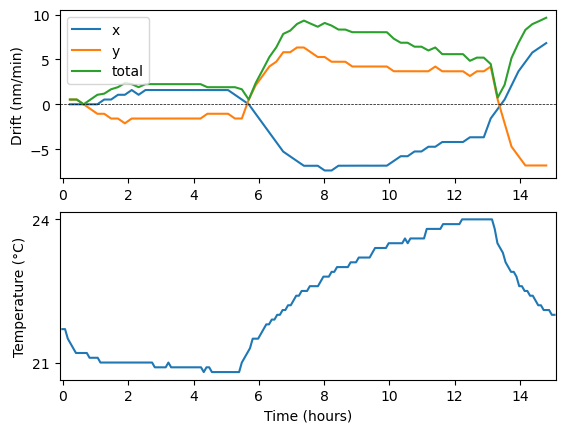

In [7]:
def data_xy_drift(ax=None):
    if ax is None: fig, ax = plt.subplots(2)

    tstart = dt.datetime(2021,12,7,16,45)
    ttotal = dt.timedelta(hours=17)

    root = '../primary_data/fig1_optimisation/2021-12-08_overnight_drift/'
    data_drift = pd.read_csv(root + '2021-12-08 overnight drift - drift report height.csv')
    data_drift['Time'] = data_drift['dt (minutes)'].cumsum().map(lambda x: x/60)
    data_drift.plot('Time', ['vx (nm/min)', 'vy (nm/min)', 'v (nm/min)'], color=['C0', 'C1', 'C2'], ax=ax[0])
    ax[0].legend(['x', 'y', 'total'])
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Drift (nm/min)')

    data_temp = pd.read_csv(root + '2021-12-08 overnight drift - c02.csv')
    data_temp.Time = data_temp.Time.map(
        lambda d: dt.datetime.strptime(d, r'%m/%d/%Y %I:%M:%S %p')
    )
    data_temp.Time = (data_temp.Time - tstart) / np.timedelta64(1, 'h')
    data_temp = data_temp.query('-.1 < Time < 15.1')
    data_temp.plot('Time', 'Temperature(C)', ax=ax[1])
    ax[1].legend().remove()
    ax[1].set_xlabel('Time (hours)')
    ax[1].set_ylabel('Temperature (°C)')
    ax[1].set_yticks([21,24])

    ax[1].set_xlim(-.1, 15.1)
    ax[0].set_xlim(-.1, 15.1)
    ax[0].axhline(0, c='k', ls='--', lw=.5)

    

data_xy_drift()

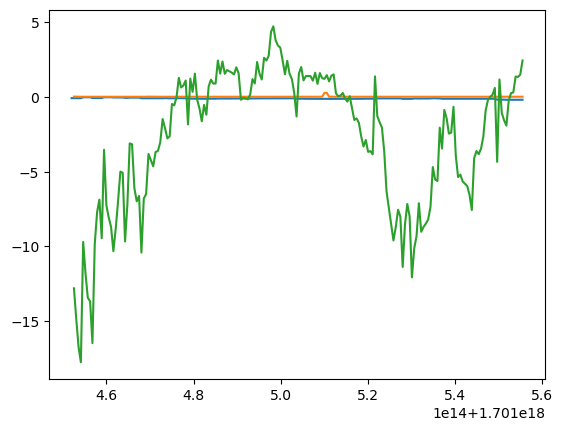

In [8]:
from skimage.registration import phase_cross_correlation

def new_drift_data(ax=None):
    if ax is None: ax = plt.gca()

    root = '../primary_data/fig1_optimisation/2023-12-01_overnight_drift/'
    doc1 = aptwrapper.read(root + '/doc1.axz')
    doc2 = aptwrapper.read(root + '/doc2.axz')
    doc3 = aptwrapper.read(root + '/doc3.axz')
    doc4 = aptwrapper.read(root + '/doc4.axz')

    tstart = np.datetime64('2023-12-01 17:24:51.063482500')
    
    maps = [
        v
        for d in [doc1, doc2, doc3, doc4]
        for k, v in d.HeightMaps.items() 
        if 'Height' in k and v.TimeStamp > tstart
    ]

    times = [m.TimeStamp.item() for m in maps]
    setpoints = [m['Tags.Setpoint'].item() for m in maps]

    # Calculate drift
    drifts = []
    rmses = []
    for i in range(len(maps)-1):
        im1 = maps[i].data
        im2 = maps[i+1].data
        transform, _, _ = phase_cross_correlation(im1, im2) 
        drifts.append(transform)
        rmses.append(np.mean((im1 - im2)))

    drifts = np.array(drifts) * maps[i].X.diff('x').isel(x=0,y=0).item()
    plt.plot(times, setpoints)
    plt.plot(times[1:], np.sqrt(drifts[:, 0]**2 + drifts[:, 1]**2))
    plt.plot(times[1:], rmses)

    # pd.read_csv(root + '/test.csv').plot(y='v (nm/min)', ax=ax)
new_drift_data()

Drift is highly dependent on CHANGING temperatures and can stabilise.

# Contact resonances

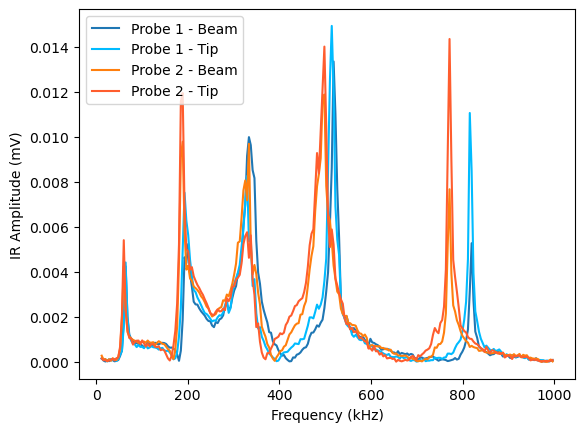

In [9]:
from scipy.optimize import curve_fit

def data_pulse_tune(ax=None):
    if ax is None: ax = plt.gca()

    root = '../primary_data/fig1_optimisation/2023-11-01_pulse_tune/'
    tb010f_high = pd.read_csv(root+'tb010f_beam.csv', names=['f', 'amplitude', 'f2', 'phase']).query('10<f')
    tb010f_tip  = pd.read_csv(root+'tb010f_tip.csv',  names=['f', 'amplitude', 'f2', 'phase']).query('10<f')
    tb010g_high = pd.read_csv(root+'tb010g_beam.csv', names=['f', 'amplitude', 'f2', 'phase']).query('10<f')
    tb010g_tip  = pd.read_csv(root+'tb010g_tip.csv',  names=['f', 'amplitude', 'f2', 'phase']).query('10<f')

    ax.plot(tb010f_high.f, tb010f_high.amplitude, label='Probe 1 - Beam', c='C0')
    ax.plot( tb010f_tip.f,  tb010f_tip.amplitude, label='Probe 1 - Tip', c='#00BBFF')

    ax.plot(tb010g_high.f, tb010g_high.amplitude, label='Probe 2 - Beam', c='C1')
    ax.plot( tb010g_tip.f,  tb010g_tip.amplitude, label='Probe 2 - Tip', c='#FF5D2E')

    ax.legend(loc='upper left')
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('IR Amplitude (mV)')
    
data_pulse_tune()

# Setpoint drift

In [10]:
from functools import cache

@cache
def get_setpoint_drift_data():
    # Read heightmaps
    root = '../primary_data/fig1_optimisation/2023-12-01_overnight_drift//'
    doc1 = aptwrapper.read(root + 'doc1.axz')
    doc2 = aptwrapper.read(root + 'doc2.axz')
    doc3 = aptwrapper.read(root + 'doc3.axz')
    doc4 = aptwrapper.read(root + 'doc4.axz')

    # Select height maps
    maps = [
        v
        for d in [doc1, doc2, doc3, doc4]
        for k, v in d.HeightMaps.items() 
        if 'Height' in k and v.TimeStamp > np.datetime64('2023-12-01 17:24:51')
    ]

    # Calculate setpoints
    setpoints = np.array([m['Tags.Setpoint'].item() for m in maps])

    # Calculate time differences
    times = np.array([h.TimeStamp.item() for h in maps]).astype('datetime64[ns]')
    timestep = (times[1:]-times[:1]) / np.timedelta64(1, 'm') # minutes

    # Calculate drift by phase correlation maximisation
    xdrift, ydrift, zdrift, rmse = [], [], [], []
    for i in range(len(maps)-1):
        im1 = aptwrapper.subtract_lines(maps[i]).data
        im2 = aptwrapper.subtract_lines(maps[i+1]).data
        transform, _, _ = phase_cross_correlation(im1, im2, upsample_factor=10) 
        xdrift.append(transform[0] * maps[i].X.diff('x').data[0,0] * 1e3)
        ydrift.append(transform[1] * maps[i].X.diff('x').data[0,0] * 1e3)
        rmse.append(np.sqrt(np.mean((im1 - im2)**2)))

    # Read temperature data
    data_temp = (
        pd.read_csv(root + 'Aranet4 0A4EF_2023-12-04T15_35_48+0100.csv')
        .assign(Time=lambda x: pd.to_datetime(x['Time(dd/mm/yyyy)'], dayfirst=True))
        .query('@times[0] < Time < @times[-1]')
    )

    return times, xdrift, ydrift, rmse, setpoints, data_temp

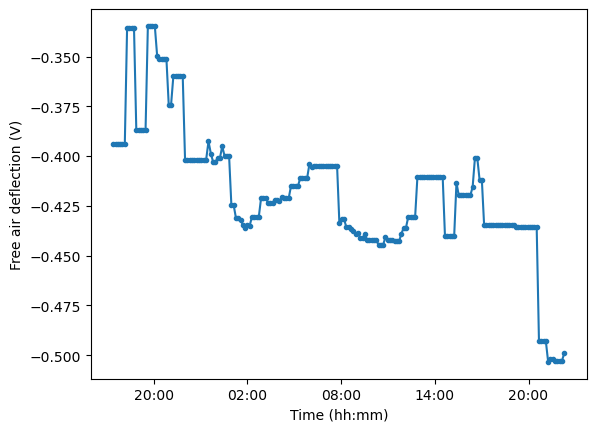

In [11]:
def plot_setpoint_drift(ax=None):
    if ax is None: ax = plt.gca()

    times, xdrift, ydrift, rmse, setpoints, data_temp = get_setpoint_drift_data()
    ax.plot(times, setpoints-.3, '.-')
    ax.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=6))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
    ax.set_xlabel('Time (hh:mm)')
    ax.set_ylabel('Free air deflection (V)')

plot_setpoint_drift()

# QC image

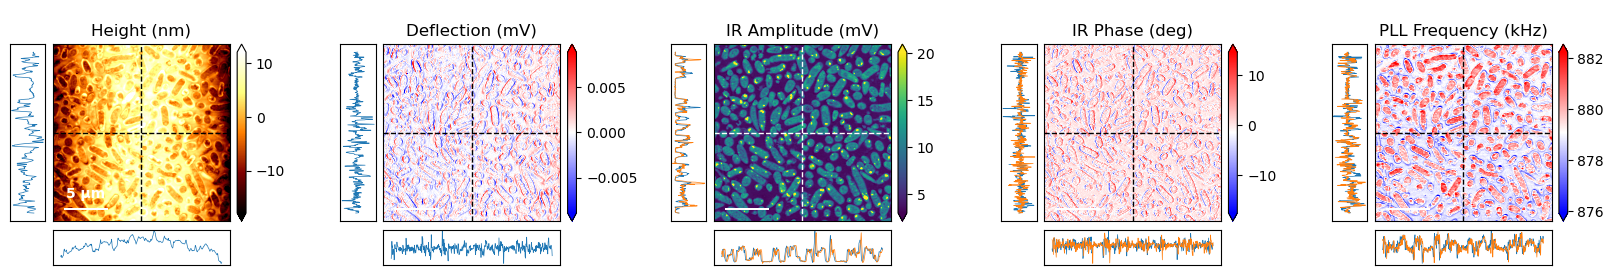

In [12]:
from matplotlib import gridspec

def plot_map_qc(hmap, hmap_retrace, ax, show_sb_val, height_frac):
    # Divide into several subplots
    gs = gridspec.GridSpecFromSubplotSpec(
        2, 3, subplot_spec=ax, wspace=.1, hspace=.08, 
        width_ratios=[.2,1,.05], 
        height_ratios=[1,.2]
    )
    ax_main = plt.subplot(gs[0, 1])
    ax_cb = plt.subplot(gs[0, 2])
    ax_trace_vert = plt.subplot(gs[0, 0])
    ax_trace_ho = plt.subplot(gs[1, 1])
    ax.axis('off')  # Hide parent axis

    # Plot heightmap
    hmap = aptwrapper.default_flatten(hmap)
    extent = [hmap.X.min(), hmap.X.max(), hmap.Y.min(), hmap.Y.max()]
    cmap = aptwrapper.default_cmap(hmap)
    vmin = np.percentile(hmap.data, 1)
    vmax = np.percentile(hmap.data, 99)
    mappable = ax_main.imshow(
        hmap.data, cmap=cmap, extent=extent, 
        vmin=vmin, vmax=vmax, aspect='auto'
    )

    c = 'w' if 'IR Amp' in hmap.Label.item() else 'k'
    ax_main.axhline(hmap.Y.mean(), color=c, lw=1, ls='--')
    ax_main.axvline(hmap.X.mean(), color=c, lw=1, ls='--')

    # Add scalebar and colorbar
    aptwrapper.add_scalebar(ax_main, show_value=show_sb_val)
    ax_main.set(xticks=[], yticks=[])
    plt.gcf().colorbar(mappable, cax=ax_cb, extend='both')
    ax_main.set_title(aptwrapper.default_cblabel(hmap))

    # Plot trace
    line_i = int(np.floor(height_frac * hmap.shape[0]))
    all_i = np.arange(hmap.shape[1])
    ax_trace_vert.plot(hmap.data[:, line_i], all_i, lw=.5)
    ax_trace_ho.plot(hmap.data[line_i], lw=.5)
    ax_trace_vert.set(xticks=[], yticks=[])
    ax_trace_ho.set(xticks=[], yticks=[])

    # Plot retrace
    if hmap_retrace is not None:
        hmap_retrace = aptwrapper.default_flatten(hmap_retrace)
        ax_trace_vert.plot(hmap_retrace.data[:, line_i], all_i, lw=.5)
        ax_trace_ho.plot(hmap_retrace.data[line_i], lw=.5)

    # Return axis aspect ratio
    _, _, w, h = ax_main.get_window_extent().bounds
    return w/h

def plot_qc_row(doc, map_index, ax=None, height_frac=.5, col_space=.4, top_pad=.05):
    if ax is None: fig, ax = plt.subplots(figsize=(20,2.5))

    # Get relevant map labels and sort in defined order
    channels_trace = [k for k in doc.HeightMaps if k.endswith(' ' +str(map_index))]
    def sorter(x):
        order = ['Height', 'Deflection', 'Amplitude', 'Phase', 
                     'IR Amplitude', 'PLL Frequency', 'IR Phase']
        for i, channel in enumerate(order): 
            if channel in x: return i
        return 999
    channels_trace = sorted(channels_trace, key=sorter)

    # Divide axis into subplots
    gs = gridspec.GridSpecFromSubplotSpec(
        2, len(channels_trace), subplot_spec=ax, 
        wspace=col_space, height_ratios=[top_pad,1]
    )
    ax.axis('off') # Hide parent axis

    # Plot each channel
    for i, channel in enumerate(channels_trace):
        ax = plt.subplot(gs[1, i])
        hmap = doc.HeightMaps[channel]
        
        # Find retrace hmap
        hmap_label_retrace = channel + ' (1)'
        if hmap_label_retrace in doc.HeightMaps:
            hmap_trace = doc.HeightMaps[hmap_label_retrace]
        else:
            hmap_trace = None


        aspect_ratio = plot_map_qc(hmap, hmap_trace, ax, show_sb_val=(i==0), height_frac=height_frac)
    return aspect_ratio

def plot_qc(ax=None):        
    doc = aptwrapper.read('../primary_data/fig3_recovery_timeline/april/doc_h1_rep1.axz')
    aspect_ratio = plot_qc_row(doc, 11, ax=ax)
    return aspect_ratio

fig, ax = plt.subplots(figsize=(20.1, 2.9))
ar = plot_qc(ax)
fig.set_figheight(fig.get_figheight()*ar)

# Composite

In [13]:
from matplotlib import gridspec

Average drift: 4.8724526226861204 nm/min
Total drift: 4305.6723177397525 nm


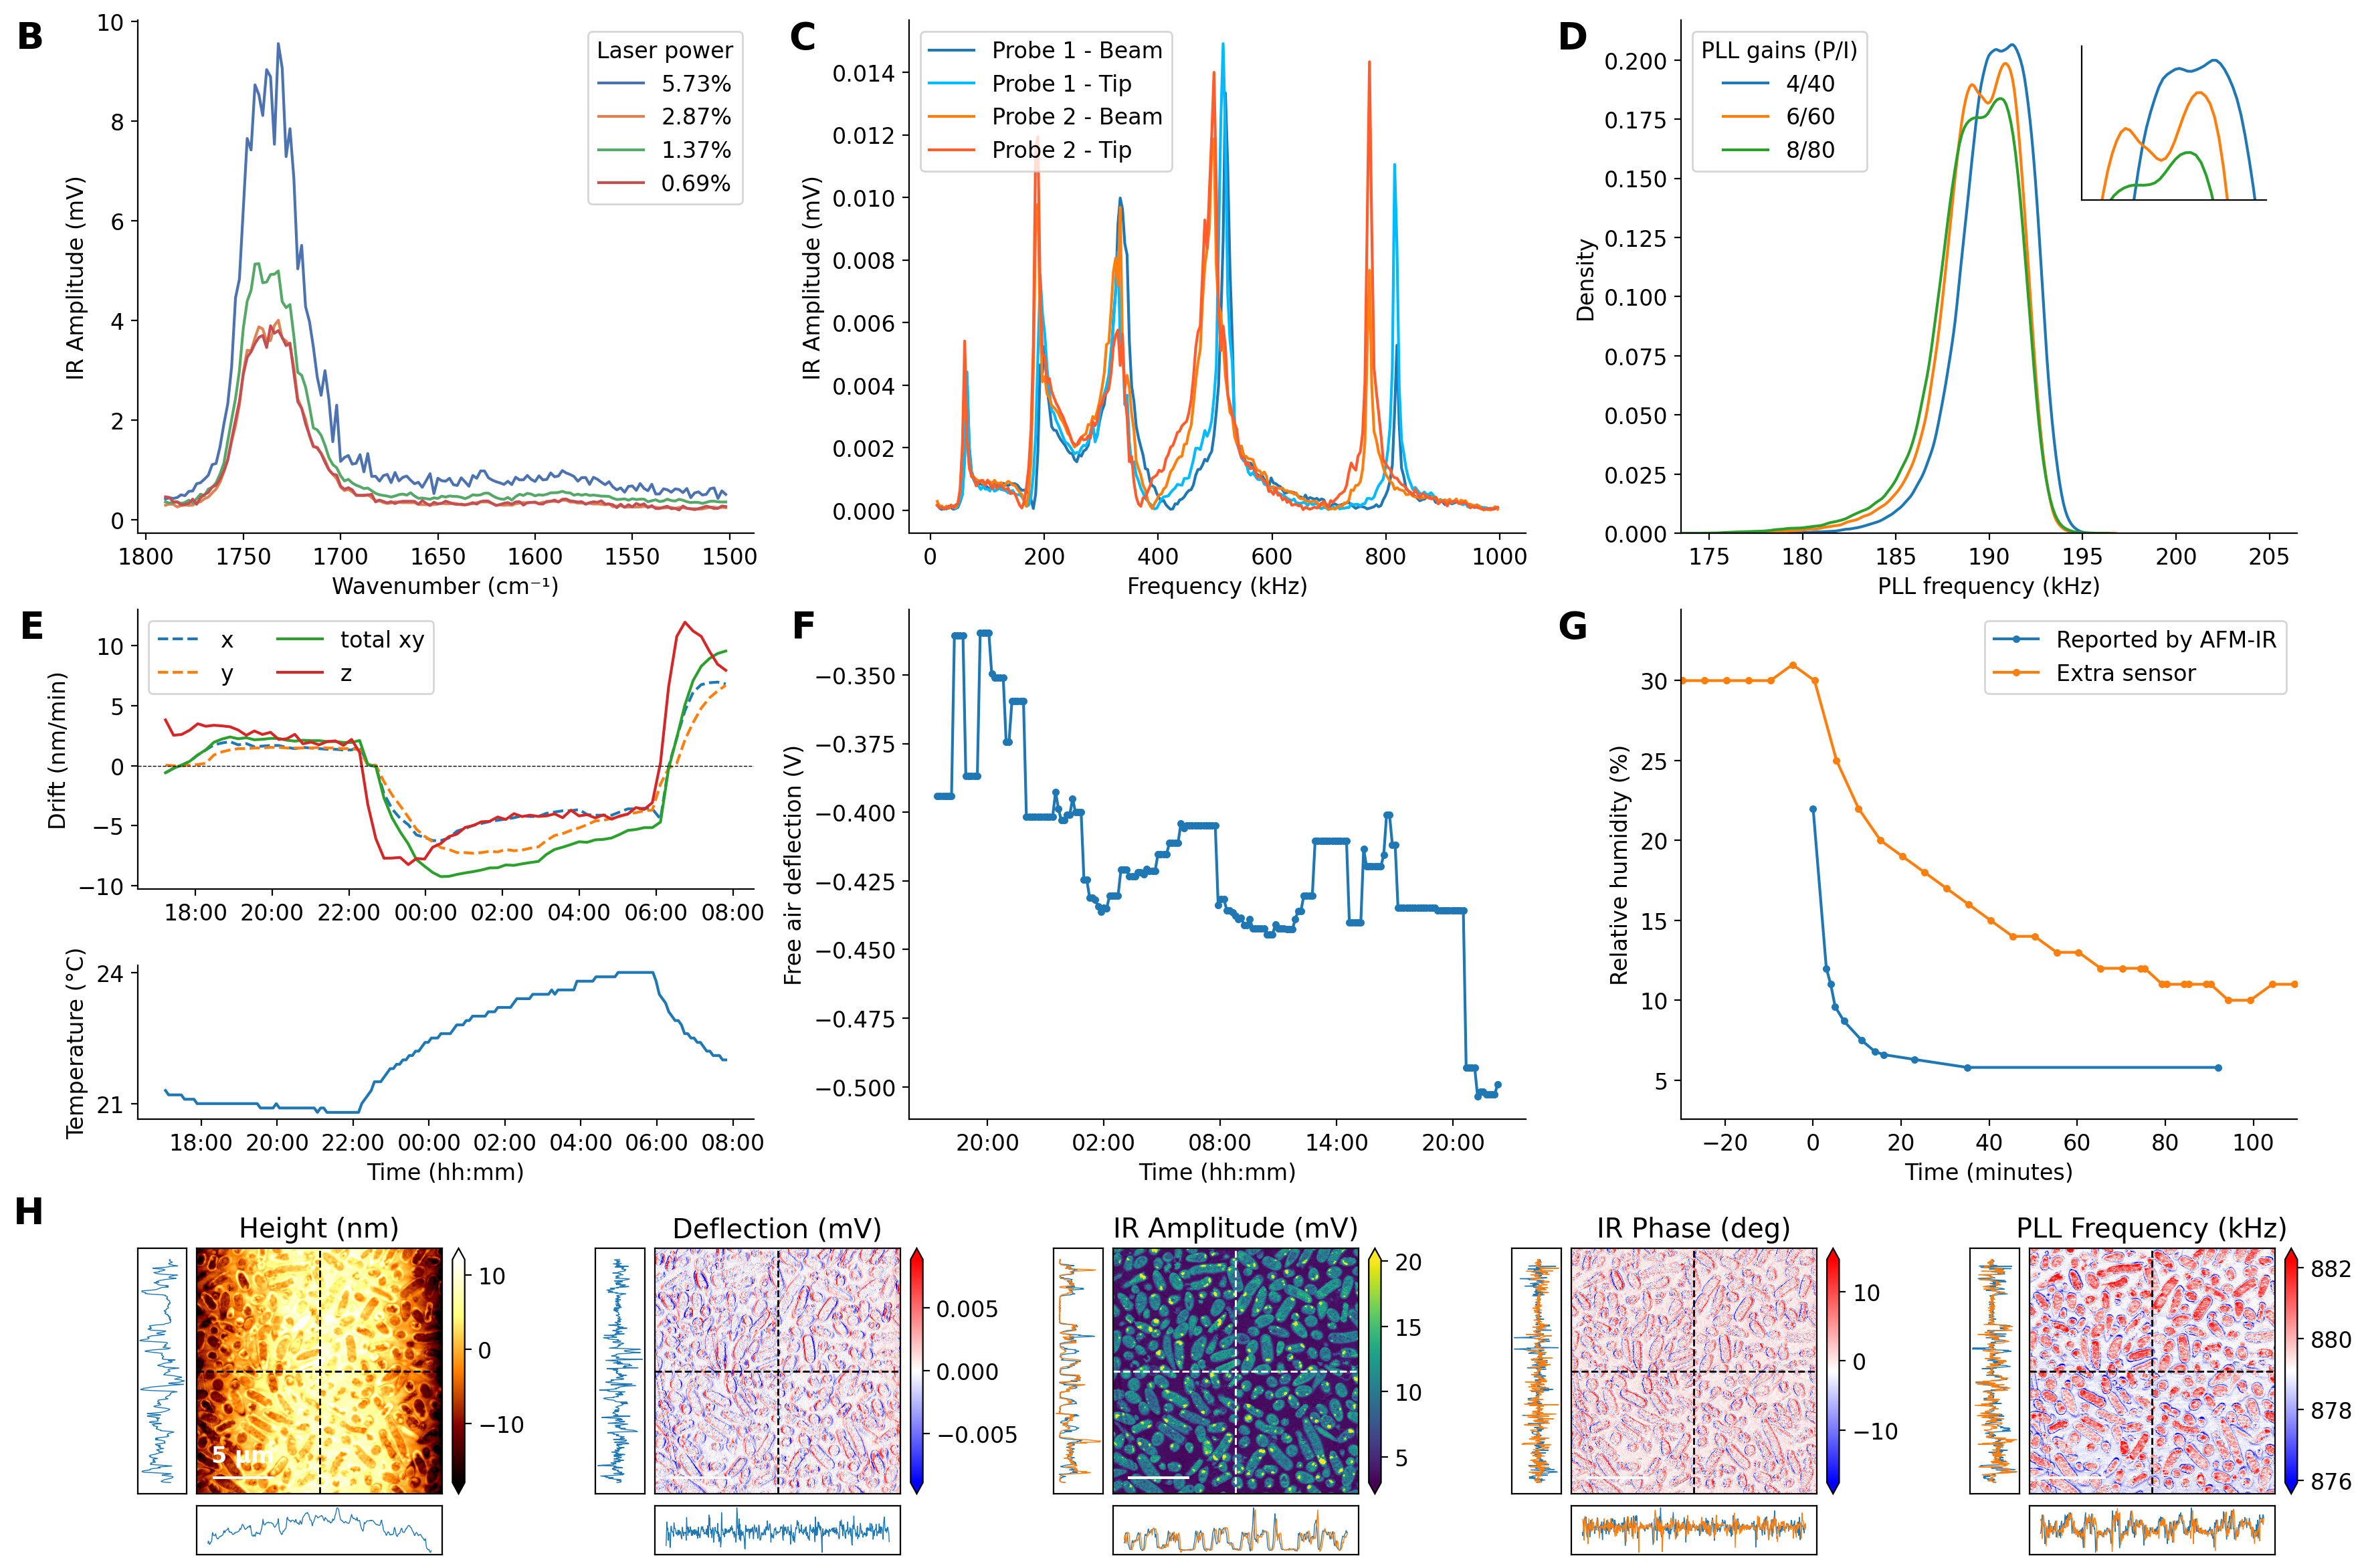

In [14]:
with plt.rc_context({
    'figure.figsize': (17,14),
    'figure.dpi': 200,
    'font.size': 12,
    'savefig.bbox': 'tight',
    'legend.loc': 'upper right',
}):
    
    fig, ax = plt.subplot_mosaic(
        gridspec_kw={'height_ratios': [1, .6/1.1, .3, .7]},
        mosaic=[
            ['b', 'c', 'd'],
            ['e1', 'f', 'g'],
            ['e2', 'f', 'g'],
            ['h', 'h', 'h'],
    ])
    plt.tight_layout(h_pad=2, w_pad=4)
    
    plot_power(ax['b'])
    data_pulse_tune(ax['c'])
    data_pll(ax['d'])
    data_drift_direct([ax['e1'], ax['e2']])
    plot_setpoint_drift(ax['f'])
    data_humidity(ax['g'])
    ar = plot_qc(ax['h'])

    # Adjust figure height so qc plots are square
    fig.set_figheight(fig.get_figheight()*ar)

    kwargs = dict(ha='right', va='top', xycoords=('axes points', 'axes fraction'), fontsize=20, fontweight='bold')
    xy = (-50, 1)
    ax['b'].annotate('B', xy, **kwargs)
    ax['c'].annotate('C', xy, **kwargs)
    ax['d'].annotate('D', xy, **kwargs)
    ax['e1'].annotate('E', xy, **kwargs)
    ax['f'].annotate('F', xy, **kwargs)
    ax['g'].annotate('G', xy, **kwargs)
    ax['h'].annotate('H', xy, **kwargs)

    for a in ax:
        if a != 'h':
            sns.despine(ax=ax[a])

    # fig.align_ylabels([ax['b'], ax['e']])
    # fig.align_ylabels([ax['c'], ax['f']])
    # fig.align_ylabels([ax['d1'], ax['d2'], ax['g']])
            
    import os
    output_directory = "../figures"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plt.savefig('../figures/figure_1.pdf', bbox_inches='tight')